## DATA 558 - Homework 4
#### Anushna Prakash
#### April 30th, 2021

##### Coordinate Descent
$$
F(\beta) = \frac{1}{2} (y - x\beta)^2 + \lambda|\beta|
$$

Implement soft-thresholding in the $n = d = 1$ case. Assume $x = y = 1$ and $\lambda = 0.5$  
$$
    \beta = 
    \begin{cases}
        \frac{xy - \lambda}{x^2}, & \text{for } xy > \lambda\\
        0, & \text{for } |xy| \leq \lambda\\
        \frac{xy + \lambda}{x^2}, & \text{for } xy < \text{-}\lambda
    \end{cases}
$$

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
def f(beta, x, y, lambda_):
    """
    Returns the objective for simplified LASSO regression.
    
    Parameters
    ----------
    beta : float
    x : float
    y : float
    lambda_ : float
        Regularization parameter
    
    Returns
    -------
    objective : float
        The objective function value
    """
    return (1/2) * (y - x * beta)**2 + lambda_* np.abs(beta)

def soft_thresholding(x, y, lambda_):
    """
    Returns the beta that minimizes the soft threshold for simplified LASSO.
    
    Parameters
    ----------
    x : float
    y : float
    lambda_ : float
        Regularization parameter
    
    Returns
    -------
    beta : float
        The beta that minimizes objective function value
    """
    if (x * y) > lambda_:
        return (x*y - lambda_) / x**2
    elif (x * y) < -lambda_:
        return (x*y + lambda_) / x**2
    else:
        return 0

In [47]:
lambda_ = 0.5
x = 1
y = 1
beta = np.arange(-2, 2, 0.5)
obj = f(beta, x, y, lambda_)
st = soft_thresholding(x, y, lambda_)

Text(0, 0.5, '$F(\\beta)$')

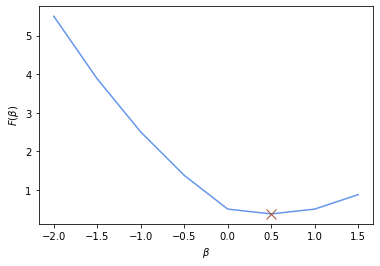

In [55]:
plt.plot(beta, obj, c = "cornflowerblue")
plt.plot(st, f(st, x, y, lambda_), marker = 'x', markersize = 10, c = 'sienna')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$F(\beta)$')

Now, assuming that $d > 1$ and $n > 1$, the objective function is:  
$$
F(\beta) = \frac{1}{2n} \sum_{i=1}^{n}(y_i - x_i^T \beta)^2 + \lambda ||\beta||_1
$$

Written with matrices, it is:  
$$
F(\beta) = \frac{1}{2n} (Y - X^T \beta)^2 + \lambda ||\beta||_1
\\ F(\beta) = \frac{1}{2n} (Y - X_{\text{-j}}^T \beta_{\text{-j}} - X_{j}^T \beta_{j})^2 + \lambda ||\beta||_1
$$

The soft thresholding minimum to the above equation is given by:
$$
    \beta = 
    \begin{cases}
        \frac{xy - \lambda}{x^2}, & \text{for } xy > \lambda\\
        0, & \text{for } |xy| \leq \lambda\\
        \frac{xy + \lambda}{x^2}, & \text{for } xy < -\lambda
    \end{cases}
$$

In [63]:
def computeobj(beta, X, y, lambda_):
    """
    Returns the objective for LASSO regression.
    
    Parameters
    ----------
    beta : 1D array
        A numpy array with shape 1 x d
    X : ndarray
        A numpy array of standardized feature variables with shape n x d
    y : 1D array
        A numpy array of standardized response variables with shape 1 x n
    lambda_ : float
        Regularization parameter
    
    Returns
    -------
    objective : float
        The objective function value
    """
    resid = y - np.dot(X, beta)
    return 1/2 * np.mean(resid**2) + lambda_ * np.linalg.norm(beta, ord = 1)

In [64]:
# Generate new data
np.random.seed(123)
X = np.random.normal(size=(10, 2))
beta = np.array([2.0, -5.0])
y = np.dot(X, beta) + np.random.normal(10)
lam = 3.0

In [67]:
def plot_objective(X, y, computeobj, lambda_, min_beta=None, iterates=None):
    nb = 100
    brange = np.linspace(-10, 10, nb)
    b1, b2 = np.meshgrid(brange, brange)
    
    z = np.array([computeobj(beta, X, y, lambda_) for 
                  beta in zip(b1.ravel(), b2.ravel())])
    
    levels = np.logspace(-5,4,100)
    
    plt.figure(figsize=(6,6))
    plt.hlines(y=0, xmin=-10, xmax=10, color='k')
    plt.vlines(x=0, ymin=-10, ymax=10, color='k')
    
    if min_beta is not None:
        plt.scatter(min_beta[0], min_beta[1], marker="x", s=100, color='k')
    
    if iterates is not None:
        # Arrows.
        for j in range(1, len(iterates)):
            plt.annotate(
                "",
                xy=iterates[j],
                xytext=iterates[j - 1],
                arrowprops={"arrowstyle": "->", "color": color, "lw": 1},
                va="center",
                ha="center",
            )
    
    plt.contour(brange, brange, z.reshape((nb, nb)), levels=levels);
    plt.show()

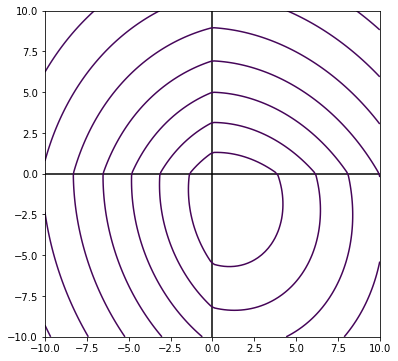

In [68]:
plot_objective(X, y, computeobj, lam)

In [99]:
def partial_min(beta, X, y, lambda_, j):
    """
    Returns the beta that partially minimizes multi-dimensional LASSO.
    
    Parameters
    ----------
    beta : 1D array
        A numpy array with shape 1 x d
    X : ndarray
        A numpy array of standardized feature variables with shape n x d
    y : 1D array
        A numpy array of standardized response variables with shape 1 x n
    lambda_ : float
        Regularization parameter
    j : int
        Index in [0, d-1] for the beta that will be partially minimized
    
    Returns
    -------
    beta : 1D array
        The betas that partially minimizes the function with respect to the jth index
    """
    n = len(y)
    X_j = X[:, j]
    X_ = np.hstack((X[:, :j], X[:, j+1:]))
    beta_j = beta[j]
    beta_ = np.hstack((beta[:j], beta[j+1:]))
    min_b = 0
    # Debugging print statements
#     print(X.shape)
#     print(X_j.shape)
#     print(X_.shape)
#     print(beta.shape)
#     print(beta_j.shape)
#     print(beta_.shape)

    r = y - X_ @ beta_ # residual excluding jth feature
    z = np.sum(X_j**2) # squared observations for the jth feature
    min_b = np.array([])
    gof = 1/n * X_j.T @ r # goodness-of-fit measure partial derivative
    
    if gof < -lambda_:
        min_b = (gof + lambda_) / (1/n * z)
    elif gof > lambda_:
        min_b = (gof - lambda_) / (1/n * z)
    
    return np.hstack((beta[:j], min_b, beta[j+1:]))

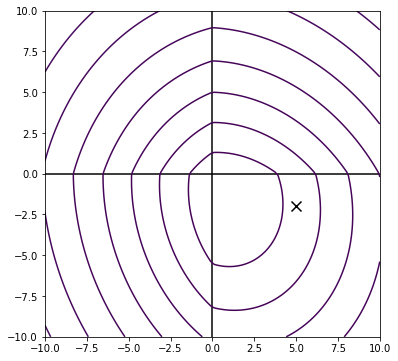

In [106]:
beta_init = np.array([5, 5])
j = 1

min_beta = partial_min(beta_init, X, y, lam, j)
plot_objective(X, y, computeobj, lam, min_beta)